In [4]:
import time
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

from qubovert.sim import anneal_qubo
from qubovert import boolean_var

import random
from dwave.cloud import Client

TOKEN = 'DEV-0d65e0f7a19d10d5c0d2fd33c1c88ea7107669a1'

from scipy import linalg
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso


In [48]:
client = Client.from_config(token=TOKEN)
print(client)

#BQMSolver(id='hybrid_binary_quadratic_model_version2')
#StructuredSolver(id='DW_2000Q_6')

print(client.get_solvers())

solver = client.get_solver(name='hybrid_binary_quadratic_model_version2')

print(solver)

Q = {(0,0):-2,(0,1):2,(0,2):3}
#Q = {(0, 0): -1, (0, 1): 0, (1, 0): 2, (1, 1): -1}

computation = solver.sample_qubo(Q,num_reads=5,time_limit=3)
#computation = solver.sample_ising(linear={0:0,1:0,2:0},quadratic=Q,time_limit=3)

[StructuredSolver(id='DW_2000Q_6'), BQMSolver(id='hybrid_binary_quadratic_model_version2'), DQMSolver(id='hybrid_discrete_quadratic_model_version1'), CQMSolver(id='hybrid_constrained_quadratic_model_version1'), StructuredSolver(id='Advantage_system6.1'), StructuredSolver(id='Advantage2_prototype1.1'), StructuredSolver(id='Advantage_system4.1')]
BQMSolver(id='hybrid_binary_quadratic_model_version2')


In [49]:
computation


In [50]:
computation.id

In [51]:
print(computation.id)
print(computation.variables)
print("\n")
print(computation.result)
print(computation.timing)
print("\n")
print(computation.energies)
print(computation.samples)
print(computation.sampleset)

None


SolverFailureError: Unknown parameter num_reads

In [19]:
computation.timing

{}

In [62]:
from dwave.system import LeapHybridSampler
Q = {('x1', 'x2'): 1, ('x1', 'z'): -2, ('x2', 'z'): -2, ('z', 'z'): 3}
sampleset = LeapHybridSampler().sample_qubo(Q, time_limit=6)

ValueError: API token not defined

In [71]:
m = {i: boolean_var('m(%d)' % i) for i in range(10)}

In [76]:
m[0]*m[1]

{('m(0)', 'm(1)'): 1}

In [3]:
def update_m(X,y,w,alpha):
    D = X.shape[1]

    m = {i: boolean_var('m(%d)' % i) for i in range(D)}

    A = np.linalg.multi_dot([np.diag(w),X.T,X,np.diag(w)])
    b = -2*np.linalg.multi_dot([np.diag(w),X.T,y])
    b = b + alpha*w*np.sign(w)

    model = 0
    for i in range(D):
        for j in range(D):
            model += m[i]*(A[i][j]+1e-9)*m[j]
        model += (b[i]+1e-9)*m[i]
        
    time_start = time.time()
    #res = anneal_qubo(model, num_anneals=10)
    res = anneal_qubo(model, num_anneals=1)
    model_solution = res.best.state
    
    m = np.array(list(model_solution.values()))
    return(m)


def update_m_dwave(X,y,w,alpha):
    TOKEN = 'DEV-0d65e0f7a19d10d5c0d2fd33c1c88ea7107669a1'
    client = Client.from_config(token=TOKEN)
    #print(client.get_solvers())
    solver = client.get_solver(name='hybrid_binary_quadratic_model_version2')
    
    D = X.shape[1]

    m = {i: boolean_var('m(%d)' % i) for i in range(D)}

    A = np.linalg.multi_dot([np.diag(w),X.T,X,np.diag(w)])
    b = -2*np.linalg.multi_dot([np.diag(w),X.T,y])
    b = b + alpha*w*np.sign(w)

    model = 0
    for i in range(D):
        for j in range(D):
            model += m[i]*(A[i][j]+1e-9)*m[j]
        model += (b[i]+1e-9)*m[i]
        
    time_start = time.time()
    #res = anneal_qubo(model, num_anneals=10)
    res = anneal_qubo(model, num_anneals=1)
    model_solution = res.best.state
    
    m = np.array(list(model_solution.values()))
    return(m)


def qubo_bsc(X,y,alpha,h_bar,hardware="classical"):
    #binary sparse coding
    #h_bar acts like planck's constant- determines strength of individual state

    D = X.shape[1]
    w = np.ones(D)*h_bar
    if hardware=="classical":
        m = update_m(X,y,w,alpha)
    elif hardware == "dwave":
        m = update_m_dwave(X,y,w,alpha)
    else:
        raise(Exception)

    return(m*w) 

In [4]:
#dataset = "diabetes"
dataset = "sparse_coding"

if dataset == "diabetes":
    #gamma=0.02
    gamma = 1.0
    X_all, y_all = datasets.load_diabetes(return_X_y=True)
    print(X_all.shape)

    X_train = X_all[:150]
    y_train = y_all[:150]

    X = X_all[:150]
    y = y_all[:150]
    
    X_val = X_all[150:]
    y_val = y_all[150:]

elif dataset == "sparse_coding":
    gamma = 1.0
    np.random.seed(42)

    N_train = 36
    N_val = 720
    N_test = 36
    N = N_train+N_val+N_test

    D = 100
    D_small = 10
    mu, sigma = 0, 1.0

    X_all = np.random.normal(mu, sigma, size=(N,D))
    X_small = np.random.normal(mu, sigma, size=(N,D_small))
    w_opt = np.abs(np.random.normal(mu,sigma,size=D_small))
    y_all = np.matmul(X_small,w_opt)

    X_all[:,:D_small] = X_small
    X_train = X_all[:N_train]
    X_val = X_all[N_train:N_train+N_val]
    X_test = X_all[N_train+N_val:]

    y_train = y_all[:N_train]
    y_val = y_all[N_train:N_train+N_val]
    y_test = y_all[N_train+N_val:]

    X = X_all[:N_train]
    y = y_all[:N_train]


N = X.shape[0]
D = X.shape[1]

X_mean = np.mean(X,axis=0)
X_std = np.std(X,axis=0)
y_mean = np.mean(y)
y_std = np.std(y)

X = (X-X_mean)/X_std
y = (y-y_mean)/y_std

########################################################################

0
alpha= 0.001000
w= [ 1.04307818e+00  1.13949085e+00  7.18462120e-01  1.26688380e+00
  2.39305447e-01  1.98205361e+00  1.30585932e+00  1.56683281e+00
  3.77098474e-01  1.39212324e+00  0.00000000e+00  0.00000000e+00
  7.08535850e-04  0.00000000e+00 -1.38641376e-03 -0.00000000e+00
  0.00000000e+00 -2.37446646e-04 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.28227954e-04  0.00000000e+00
  0.00000000e+00 -3.46650740e-03 -0.00000000e+00  3.83030064e-03
 -0.00000000e+00 -2.62969570e-04  0.00000000e+00  1.32365400e-03
  0.00000000e+00 -0.00000000e+00  7.01868041e-04  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -2.66799311e-04 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.21991414e-03 -3.35239990e-03
  0.00000000e+00 -0.00000000e+00 -5.68483587e-04  0.00000000e+00
 -7.05093944e-05  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.

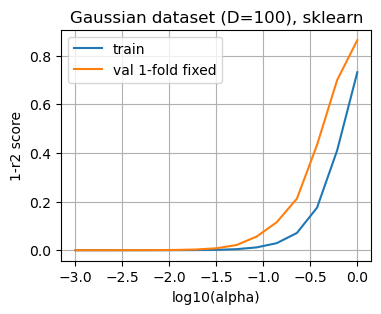

In [30]:
#algorithm:sklearn lasso

########################################################################
#gamma=0.02
#gamma = 1.0

########################################################################



#alphas = np.logspace(-100, 2, 30)
alphas = np.logspace(-3, 0, 15)

scores_train = []
scores_val = []
plot_y = []

for i in range(len(alphas)):
    print(i)
    print("alpha= %f"%alphas[i])
    lasso = Lasso(alpha=alphas[i],fit_intercept=False,random_state=0, max_iter=10000)
    lasso.fit(X_train, y_train)
    

    
    #y_train_pred = np.matmul(X_train,lasso.coef_)+lasso.intercept_
    #y_val_pred = np.matmul(X_val,lasso.coef_)+lasso.intercept_
    y_train_pred = np.matmul(X_train,lasso.coef_)
    y_val_pred = np.matmul(X_val,lasso.coef_)

    r2_train = lasso.score(X_train,y_train)
    r2_val = lasso.score(X_val,y_val)

    SSres_train = np.dot(y_train_pred-y_train,y_train_pred-y_train)
    SSres_val = np.dot(y_val_pred-y_val,y_val_pred-y_val)

    SStot_train = np.dot(y_mean-y_train,y_mean-y_train)
    SStot_val = np.dot(np.mean(y_val)-y_val,np.mean(y_val)-y_val)

    r2_train_calc = 1-SSres_train/SStot_train
    r2_val_calc = 1-SSres_val/SStot_val

    one_norm = np.matmul(np.abs(lasso.coef_),np.ones(D))
    zero_norm = np.matmul(np.where(np.abs(lasso.coef_)>0,1,0),np.ones(D))

    #scores.append(r2_val)
    scores_train.append(r2_train)
    scores_val.append(r2_val)
    #scores_train.append(sqloss_train)
    #scores_val.append(sqloss_val)
    plot_y.append(zero_norm)
    
    print("w= %s"%(str(lasso.coef_)))
    print("r2_train= %f"%r2_train)
    print("r2_val= %f"%r2_val)
    print("r2_val_calc= %f"%r2_val_calc)
    print("sqloss_val= %f"%SSres_val)
    print("one_norm= %f"%one_norm)
    print("zero_norm= %f"%zero_norm)
    print("\n")

fig1 = plt.figure(figsize=(4,3))
ax1 = fig1.add_subplot(111)

#plt.rcParams['figure.figsize'] = [8, 5]
ax1.plot(np.log10(alphas),1-np.array(scores_train),label="train")
ax1.plot(np.log10(alphas),1-np.array(scores_val),label="val 1-fold fixed")
#ax1.plot(np.log10(alphas),plot_y)
ax1.set_title("Gaussian dataset (D=100), sklearn")
ax1.set_xlabel("log10(alpha)")
ax1.set_ylabel("1-r2 score")
#ax1.set_ylabel("|w|_0 zero norm")
ax1.grid()
ax1.legend()
fig1.savefig('lasso_f1.png')
#plt.show()

print("conventional lasso finished")
#lasso = None
print("*"*128)
print("\n")

########################################################################






0
alpha= 0.100000
m*w= [0.2 0.2 0.  0.  0.  0.2 0.2 0.2 0.2 0.2 0.  0.  0.  0.  0.  0.2 0.  0.
 0.  0.  0.2 0.2 0.  0.2 0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.2 0.  0.
 0.2 0.  0.  0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.2 0.2 0.2 0.  0.  0.2 0.2 0.  0.2 0.  0.2
 0.2 0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.2 0.2 0.  0.2
 0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0. ]
[-0.34906817  1.27148037 -5.51819752  2.47847278  1.61504492 -0.44562051
 -4.17880092  6.06704666  1.66903782  0.96293833  3.02934792  4.19851538
 -1.37060821  3.60190689  0.51171107 -1.08798446 -0.64562463  0.28824695
  0.69696916  4.23117977 -3.29043009 -0.03056281 -1.7133623  -2.51298373
 -1.87552883  4.01550161  4.22263879 -3.32237178 -1.74304271 -3.58556043
  6.22316771  2.02807619  3.76353139 -1.09095308  6.11366585  3.39098755]
r2_train= 0.916972
r2_val= -0.246135
sqloss_val= 13589.124920
one_norm= 6.400000
zero_norm= 32.000000


1
alpha= 0.143845
m*w= [0.2 0.

m*w= [0.2 0.2 0.  0.2 0.  0.2 0.2 0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.2 0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2
 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.2 0.  0.  0.
 0.  0.  0.2 0.  0.  0.  0.  0.  0.  0. ]
[ 0.3765683   2.0028335  -6.08626945  2.79440225  0.36809745 -0.78450412
 -3.1160328   6.16120201  1.98150128  1.34627791  2.82062418  2.49194918
 -1.04224237  4.77432537 -0.31740816 -1.93532015  0.03660289 -1.05695923
 -1.14876658  3.39718896 -1.41252497  0.67004235 -1.86751823 -1.82483097
  0.40429152  2.01520952  2.33877218 -2.73606557 -1.16062528 -2.44204085
  6.27878162  3.24219666  3.33156341 -1.95311865  4.9425723   4.72799147]
r2_train= 0.876927
r2_val= 0.240867
sqloss_val= 8278.362890
one_norm= 3.000000
zero_norm= 15.000000


10
alpha= 3.792690
m*w= [0.2 0.2 0.  0.2 0.  0.2 0.

m*w= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0.76718797 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797
 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797
 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797
 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797
 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797
 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797 0.76718797]
r2_train= 0.000000
r2_val= -0.025184
sqloss_val= 11179.646143
one_norm= 0.000000
zero_norm= 0.000000


19
alpha= 100.000000
m*w= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

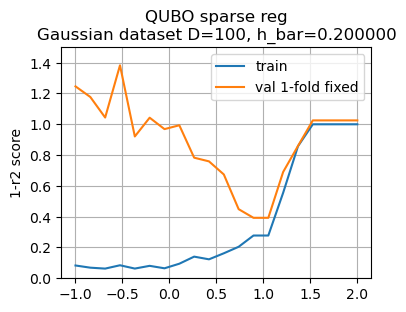

In [5]:
#algorithm: classical simulation qubo_bsc

h_bar = 0.2

n_alphas = 10
alphas = np.logspace(-1, 2, n_alphas)
#alphas = np.array([15.0])
#alphas = np.logspace(-3, 0, 15)

scores_train = []
scores_val = []
plot_y = np.zeros(n_alphas)

for i in range(len(alphas)):
    print(i)
    print("alpha= %f"%alphas[i])

    #mw = custom_algo(X,y,alphas[i],gamma)
    mw = qubo_bsc(X=X,y=y,alpha=alphas[i],h_bar=h_bar)
    
    #lasso = Lasso(alpha=alphas[i],fit_intercept=False,random_state=0, max_iter=10000)
    #lasso.fit(X, y)
    #mw = lasso.coef_
    
    y_train_pred = np.matmul(X,mw)*y_std+y_mean
    y_val_pred = np.matmul((X_val-X_mean)/X_std,mw)*y_std+y_mean
    SSres_train = np.dot(y_train_pred-y_train,y_train_pred-y_train)
    SSres_val = np.dot(y_val_pred-y_val,y_val_pred-y_val)

    SStot_train = np.dot(y_mean-y_train,y_mean-y_train)
    SStot_val = np.dot(np.mean(y_val)-y_val,np.mean(y_val)-y_val)

    r2_train = 1-SSres_train/SStot_train
    r2_val = 1-SSres_val/SStot_val
    
    one_norm = np.matmul(np.abs(mw),np.ones(D))
    zero_norm = np.matmul(np.where(np.abs(mw)>0,1,0),np.ones(D))
    #print(zero_norm)
    
    scores_train.append(r2_train)
    scores_val.append(r2_val)
    #plot_y.append(zero_norm)
    plot_y[i] = zero_norm
    #print(plot_y)
    
    print("m*w= %s"%(str(mw)))
    print(y_train_pred)
    print("r2_train= %f"%r2_train)
    print("r2_val= %f"%r2_val)
    print("sqloss_val= %f"%SSres_val)
    print("one_norm= %f"%one_norm)
    print("zero_norm= %f"%zero_norm)
    print("\n")

fig2 = plt.figure(figsize=(4,3))
ax2 = fig2.add_subplot(111)

#plt.rcParams['figure.figsize'] = [8, 5]
ax2.plot(np.log10(alphas),1-np.array(scores_train),label="train")
ax2.plot(np.log10(alphas),1-np.array(scores_val),label="val 1-fold fixed")
#ax2.plot(np.log10(alphas),plot_y)
title_text = "QUBO sparse reg\nGaussian dataset D=100, h_bar=%f"%h_bar
ax2.set_title(title_text)
#ax2.set_xlabel("log10(alpha)")
ax2.set_ylabel("1-r2 score")
#ax2.set_ylabel("|w|_0 zero norm")
ax2.set_ylim(0.0,1.5)
ax2.grid()
ax2.legend()
fig2.savefig('lasso_f2.png')

In [140]:
#algorithm: dwave hybrid

h_bar = 0.2

n_alphas = 1000
alphas = np.logspace(-1, 2, n_alphas)

D = X.shape[1]
Q = {}

for i in range(len(alphas)):
    print(i)
    print("alpha= %f"%alphas[i])
    alpha = alphas[i]
    
    #embed to Q dict
    #hybrid solver: max_variables=1M, max_biases=20M (i.e. connections between variables)
    
    w = np.ones(D)*h_bar
    
    A = np.linalg.multi_dot([np.diag(w),X.T,X,np.diag(w)])
    b = -2*np.linalg.multi_dot([np.diag(w),X.T,y])
    b = b + alpha*w*np.sign(w)
    
    #Q = {(0,0):1,(0,1):2,(0,2):3}

    for j in range(0,D):
        Q[(i*D+j,i*D+j)] = A[j][j]+b[j]+1e-9
        for k in range(j+1,D):
            Q[(i*D+j,i*D+k)] = 2*A[j][k]+1e-9 #*2 because A is symmetric
                
            
            
    
    

0
alpha= 0.100000
1
alpha= 0.100694
2
alpha= 0.101393
3
alpha= 0.102096
4
alpha= 0.102804
5
alpha= 0.103518
6
alpha= 0.104236
7
alpha= 0.104959
8
alpha= 0.105688
9
alpha= 0.106421
10
alpha= 0.107159
11
alpha= 0.107903
12
alpha= 0.108652
13
alpha= 0.109405
14
alpha= 0.110165
15
alpha= 0.110929
16
alpha= 0.111699
17
alpha= 0.112474
18
alpha= 0.113254
19
alpha= 0.114040
20
alpha= 0.114831
21
alpha= 0.115628
22
alpha= 0.116430
23
alpha= 0.117238
24
alpha= 0.118052
25
alpha= 0.118871
26
alpha= 0.119696
27
alpha= 0.120526
28
alpha= 0.121362
29
alpha= 0.122204
30
alpha= 0.123052
31
alpha= 0.123906
32
alpha= 0.124766
33
alpha= 0.125632
34
alpha= 0.126503
35
alpha= 0.127381
36
alpha= 0.128265
37
alpha= 0.129155
38
alpha= 0.130051
39
alpha= 0.130954
40
alpha= 0.131862
41
alpha= 0.132777
42
alpha= 0.133698
43
alpha= 0.134626
44
alpha= 0.135560
45
alpha= 0.136501
46
alpha= 0.137448
47
alpha= 0.138402
48
alpha= 0.139362
49
alpha= 0.140329
50
alpha= 0.141303
51
alpha= 0.142283
52
alpha= 0.143270
53


445
alpha= 2.169384
446
alpha= 2.184436
447
alpha= 2.199593
448
alpha= 2.214855
449
alpha= 2.230223
450
alpha= 2.245698
451
alpha= 2.261280
452
alpha= 2.276970
453
alpha= 2.292769
454
alpha= 2.308678
455
alpha= 2.324697
456
alpha= 2.340827
457
alpha= 2.357069
458
alpha= 2.373424
459
alpha= 2.389893
460
alpha= 2.406475
461
alpha= 2.423173
462
alpha= 2.439986
463
alpha= 2.456916
464
alpha= 2.473964
465
alpha= 2.491130
466
alpha= 2.508415
467
alpha= 2.525820
468
alpha= 2.543346
469
alpha= 2.560993
470
alpha= 2.578763
471
alpha= 2.596656
472
alpha= 2.614673
473
alpha= 2.632815
474
alpha= 2.651084
475
alpha= 2.669478
476
alpha= 2.688001
477
alpha= 2.706652
478
alpha= 2.725433
479
alpha= 2.744343
480
alpha= 2.763385
481
alpha= 2.782559
482
alpha= 2.801867
483
alpha= 2.821308
484
alpha= 2.840884
485
alpha= 2.860596
486
alpha= 2.880444
487
alpha= 2.900430
488
alpha= 2.920556
489
alpha= 2.940820
490
alpha= 2.961225
491
alpha= 2.981772
492
alpha= 3.002462
493
alpha= 3.023295
494
alpha= 3.044272


867
alpha= 40.142425
868
alpha= 40.420958
869
alpha= 40.701425
870
alpha= 40.983837
871
alpha= 41.268208
872
alpha= 41.554553
873
alpha= 41.842885
874
alpha= 42.133217
875
alpha= 42.425564
876
alpha= 42.719940
877
alpha= 43.016358
878
alpha= 43.314832
879
alpha= 43.615378
880
alpha= 43.918009
881
alpha= 44.222740
882
alpha= 44.529585
883
alpha= 44.838559
884
alpha= 45.149678
885
alpha= 45.462955
886
alpha= 45.778405
887
alpha= 46.096045
888
alpha= 46.415888
889
alpha= 46.737951
890
alpha= 47.062248
891
alpha= 47.388796
892
alpha= 47.717609
893
alpha= 48.048704
894
alpha= 48.382097
895
alpha= 48.717802
896
alpha= 49.055837
897
alpha= 49.396217
898
alpha= 49.738960
899
alpha= 50.084080
900
alpha= 50.431595
901
alpha= 50.781521
902
alpha= 51.133875
903
alpha= 51.488675
904
alpha= 51.845935
905
alpha= 52.205675
906
alpha= 52.567911
907
alpha= 52.932661
908
alpha= 53.299941
909
alpha= 53.669769
910
alpha= 54.042164
911
alpha= 54.417143
912
alpha= 54.794723
913
alpha= 55.174924
914
alpha= 55

In [141]:
client = Client.from_config(token=TOKEN)
print(client)

#BQMSolver(id='hybrid_binary_quadratic_model_version2')
#StructuredSolver(id='DW_2000Q_6')

print(client.get_solvers())

solver = client.get_solver(name='hybrid_binary_quadratic_model_version2')

print(solver)


computation = solver.sample_qubo(Q,time_limit=5.5)

[StructuredSolver(id='DW_2000Q_6'), BQMSolver(id='hybrid_binary_quadratic_model_version2'), DQMSolver(id='hybrid_discrete_quadratic_model_version1'), StructuredSolver(id='Advantage_system4.1'), CQMSolver(id='hybrid_constrained_quadratic_model_version1'), StructuredSolver(id='Advantage_system6.1'), StructuredSolver(id='Advantage2_prototype1.1')]
BQMSolver(id='hybrid_binary_quadratic_model_version2')


In [142]:
print(computation)
print(computation.id)
print(computation.variables)
print("\n")
print(computation.result)
print(computation.timing)
print("\n")
print(computation.energies)
print(computation.samples)
print(computation.sampleset.to_pandas_dataframe())
print(computation.sampleset.variables)
print(computation.sampleset.info)

None


SolverFailureError: Attempting to run a problem for less than the allowed minimum time_limit 600.0 s

0
alpha= 0.100000
m*w= [0.2 0.2 0.  0.2 0.  0.2 0.2 0.2 0.  0.2 0.  0.  0.  0.  0.  0.2 0.  0.
 0.  0.  0.2 0.2 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.2 0.  0.2 0.2 0.
 0.2 0.  0.  0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.2 0.  0.2 0.  0.2
 0.2 0.2 0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.2 0.2 0.  0.  0.
 0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0. ]
[ 1.11028487  2.63483427 -6.52929536  2.97908567  2.33947306 -0.96654426
 -6.57199715  7.24065531  0.99465158  0.01376616  1.34062792  4.14771692
 -1.57235411  4.78307849 -0.86880113 -1.96105385  0.23472488 -1.36923923
  0.56604269  3.52672401 -2.31458086  0.29589058 -1.70312347 -2.21084373
 -0.03828379  4.0982483   3.79028596 -3.52204841 -1.53302518 -2.42115466
  5.10570958  2.78731269  2.95611091 -0.1617112   6.48341686  3.93418259]
r2_train= 0.946816
r2_val= -0.157282
sqloss_val= 12620.182025
one_norm= 6.000000
zero_norm= 30.000000


1
alpha= 0.143845
m*w= [0.2 0.2

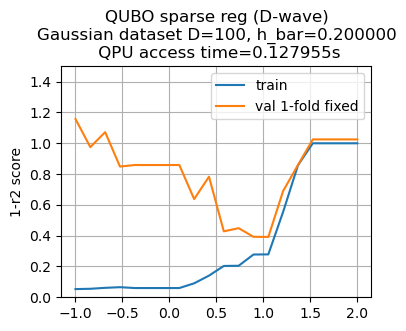

In [135]:


scores_train = []
scores_val = []
plot_y = np.zeros(n_alphas)

for i in range(len(alphas)):
    print(i)
    print("alpha= %f"%alphas[i])

    #mw = custom_algo(X,y,alphas[i],gamma)
    #mw = qubo_bsc(X=X,y=y,alpha=alphas[i],h_bar=h_bar)
    
    D = X.shape[1]
    w = np.ones(D)*h_bar
    m = computation.samples[0][i*D:(i+1)*D]
    mw = m*w
    
    #lasso = Lasso(alpha=alphas[i],fit_intercept=False,random_state=0, max_iter=10000)
    #lasso.fit(X, y)
    #mw = lasso.coef_
    
    y_train_pred = np.matmul(X,mw)*y_std+y_mean
    y_val_pred = np.matmul((X_val-X_mean)/X_std,mw)*y_std+y_mean
    SSres_train = np.dot(y_train_pred-y_train,y_train_pred-y_train)
    SSres_val = np.dot(y_val_pred-y_val,y_val_pred-y_val)

    SStot_train = np.dot(y_mean-y_train,y_mean-y_train)
    SStot_val = np.dot(np.mean(y_val)-y_val,np.mean(y_val)-y_val)

    r2_train = 1-SSres_train/SStot_train
    r2_val = 1-SSres_val/SStot_val
    
    one_norm = np.matmul(np.abs(mw),np.ones(D))
    zero_norm = np.matmul(np.where(np.abs(mw)>0,1,0),np.ones(D))
    #print(zero_norm)
    
    scores_train.append(r2_train)
    scores_val.append(r2_val)
    #plot_y.append(zero_norm)
    plot_y[i] = zero_norm
    #print(plot_y)
    
    print("m*w= %s"%(str(mw)))
    print(y_train_pred)
    print("r2_train= %f"%r2_train)
    print("r2_val= %f"%r2_val)
    print("sqloss_val= %f"%SSres_val)
    print("one_norm= %f"%one_norm)
    print("zero_norm= %f"%zero_norm)
    print("\n")

fig2 = plt.figure(figsize=(4,3))
ax2 = fig2.add_subplot(111)

#plt.rcParams['figure.figsize'] = [8, 5]
ax2.plot(np.log10(alphas),1-np.array(scores_train),label="train")
ax2.plot(np.log10(alphas),1-np.array(scores_val),label="val 1-fold fixed")
#ax2.plot(np.log10(alphas),plot_y)
title_text = "QUBO sparse reg (D-wave)\nGaussian dataset D=100, h_bar=%f"%h_bar
title_text += "\n QPU access time=%fs"%(computation.sampleset.info["qpu_access_time"]/1e6)
ax2.set_title(title_text)
#ax2.set_xlabel("log10(alpha)")
ax2.set_ylabel("1-r2 score")
#ax2.set_ylabel("|w|_0 zero norm")
ax2.set_ylim(0.0,1.5)
ax2.grid()
ax2.legend()
fig2.savefig('lasso_f2.png')

In [ ]:
h_bar = 0.1
hardware = "classical"
#hardware = "dwave"

alphas = np.logspace(-1, 2, 10)
#alphas = np.array([15.0])
#alphas = np.logspace(-3, 0, 15)

scores_train = []
scores_val = []
plot_y = np.zeros(30)

for i in range(len(alphas)):
    print(i)
    print("alpha= %f"%alphas[i])

    #mw = custom_algo(X,y,alphas[i],gamma)
    mw = qubo_bsc(X=X,y=y,alpha=alphas[i],h_bar=h_bar,hardware=hardware)
    
    #lasso = Lasso(alpha=alphas[i],fit_intercept=False,random_state=0, max_iter=10000)
    #lasso.fit(X, y)
    #mw = lasso.coef_
    
    y_train_pred = np.matmul(X,mw)*y_std+y_mean
    y_val_pred = np.matmul((X_val-X_mean)/X_std,mw)*y_std+y_mean
    SSres_train = np.dot(y_train_pred-y_train,y_train_pred-y_train)
    SSres_val = np.dot(y_val_pred-y_val,y_val_pred-y_val)

    SStot_train = np.dot(y_mean-y_train,y_mean-y_train)
    SStot_val = np.dot(np.mean(y_val)-y_val,np.mean(y_val)-y_val)

    r2_train = 1-SSres_train/SStot_train
    r2_val = 1-SSres_val/SStot_val
    
    one_norm = np.matmul(np.abs(mw),np.ones(D))
    zero_norm = np.matmul(np.where(np.abs(mw)>0,1,0),np.ones(D))
    #print(zero_norm)
    
    scores_train.append(r2_train)
    scores_val.append(r2_val)
    #plot_y.append(zero_norm)
    plot_y[i] = zero_norm
    #print(plot_y)
    
    print("m*w= %s"%(str(mw)))
    print(y_train_pred)
    print("r2_train= %f"%r2_train)
    print("r2_val= %f"%r2_val)
    print("sqloss_val= %f"%SSres_val)
    print("one_norm= %f"%one_norm)
    print("zero_norm= %f"%zero_norm)
    print("\n")

fig2 = plt.figure(figsize=(4,3))
ax2 = fig2.add_subplot(111)

#plt.rcParams['figure.figsize'] = [8, 5]
ax2.plot(np.log10(alphas),1-np.array(scores_train),label="train")
ax2.plot(np.log10(alphas),1-np.array(scores_val),label="val 1-fold fixed")
#ax2.plot(np.log10(alphas),plot_y)
title_text = "QUBO sparse reg\nGaussian dataset D=100, h_bar=%f"%h_bar
ax2.set_title(title_text)
#ax2.set_xlabel("log10(alpha)")
ax2.set_ylabel("1-r2 score")
#ax2.set_ylabel("|w|_0 zero norm")
ax2.set_ylim(0.0,1.5)
ax2.grid()
ax2.legend()
fig2.savefig('lasso_f2.png')

In [14]:
X, y = datasets.load_diabetes(return_X_y=True)
print(X.shape)

D = X.shape[1]

X_train = X[:150]
y_train = y[:150]
X_val = X[150:200]
y_val = y[150:200]


(442, 10)


In [24]:
np.random.seed(42)

N_train = 360
N_train_folds = 10
N_val = 720
N = N_train+N_val

D = 200
D_small = 20
mu, sigma = 0, 1.0

X_all = np.random.normal(mu, sigma, size=(N,D))
X_small = np.random.normal(mu, sigma, size=(N,D_small))
w_opt = np.random.normal(mu,sigma,size=D_small)
y_all = np.matmul(X_small,w_opt)

X_all[:,:D_small] = X_small
X_train = X_all[:N_train]
X_val = X_all[N_train:N_train+N_val]

y_train = y_all[:N_train]
y_val = y_all[N_train:N_train+N_val]

In [25]:
#alphas = np.logspace(-100, 2, 30)
alphas = np.logspace(-5, 0, 50)

scores_train = []
scores_val = []

for i in range(len(alphas)):
    print(i)
    lasso = Lasso(alpha=alphas[i],random_state=0, max_iter=10000)
    lasso.fit(X_train, y_train)
    y_train_pred = np.matmul(X_train,lasso.coef_)
    y_val_pred = np.matmul(X_val,lasso.coef_)
    r2_train = lasso.score(X_train,y_train)
    r2_val = lasso.score(X_val,y_val)
    sqloss_train = np.dot(y_train_pred-y_train,y_train_pred-y_train)
    sqloss_val = np.dot(y_val_pred-y_val,y_val_pred-y_val)
    
    one_norm = np.matmul(np.abs(lasso.coef_),np.ones(D))
    zero_norm = np.matmul(np.where(np.abs(lasso.coef_)>0,1,0),np.ones(D))
    
    #scores.append(r2_val)
    scores_train.append(r2_train)
    scores_val.append(r2_val)
    #scores_train.append(sqloss_train)
    #scores_val.append(sqloss_val)
    
    print(lasso.coef_)
    print(r2_val)
    print(one_norm)
    print(zero_norm)
    print("\n")

0
[ 1.81840847e+00  3.92078417e-01 -3.40712410e-01  7.92916341e-01
  7.76751108e-01  2.03346155e-01  1.65660377e+00 -8.93797313e-01
 -3.65350804e-01 -5.81562373e-02  9.08286004e-01 -1.05718773e-02
 -1.34260880e+00 -6.85389631e-01  9.99084073e-01  9.69932481e-01
 -1.18409289e+00 -3.52807736e-01 -5.75859602e-01  5.50477397e-01
  1.10691621e-04 -1.76374690e-04  1.33414665e-04 -0.00000000e+00
 -2.13657607e-04 -2.20616455e-04  8.16392069e-05 -0.00000000e+00
  0.00000000e+00 -2.71709202e-04  8.07470861e-05  6.49372899e-06
 -3.80702472e-04  1.82187802e-04 -1.86112468e-04 -1.46599041e-04
 -3.84754640e-04 -2.54125278e-04  1.46344428e-04 -3.55899290e-04
 -2.48248514e-04  1.97200602e-05  1.06141457e-04  5.12876235e-05
 -3.77035216e-04  1.08892175e-04 -2.38705773e-05  1.30853907e-05
  2.36907581e-04  2.84899584e-04 -3.42386279e-04 -2.29214415e-05
  4.71803540e-05  1.81616131e-04  0.00000000e+00  1.48719573e-05
 -1.20298443e-04 -4.75072246e-05 -3.66797872e-04 -2.83654949e-05
 -1.11512332e-05 -2.962

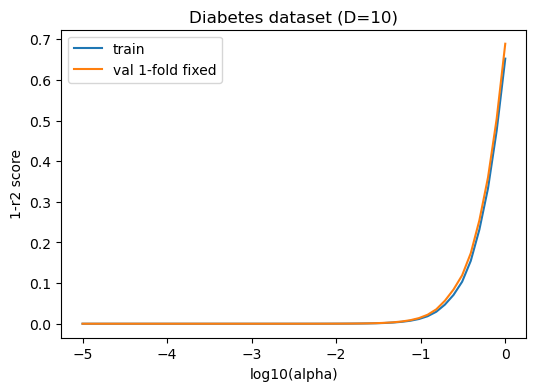

In [26]:
fig1 = plt.figure(figsize=(6,4))
ax1 = fig1.add_subplot(111)

#plt.rcParams['figure.figsize'] = [8, 5]
ax1.plot(np.log10(alphas),1-np.array(scores_train),label="train")
ax1.plot(np.log10(alphas),1-np.array(scores_val),label="val 1-fold fixed")
ax1.set_title("Diabetes dataset (D=10)")
ax1.set_xlabel("log10(alpha)")
ax1.set_ylabel("1-r2 score")
ax1.legend()
plt.show()

In [23]:
#alphas = np.logspace(-100, 2, 30)
alphas = np.logspace(-5, 2, 50)

scores_train = []
scores_val = []

for i in range(len(alphas)):
    print(i)
    #lasso = Lasso(alpha=alphas[i],random_state=0, max_iter=10000)
    #lasso.fit(X_train, y_train)
    w = qubo_bsc(X=X_train,y=y_train,alpha=alphas[i],h_bar=10)
    y_train_pred = np.matmul(X_train,w)
    y_val_pred = np.matmul(X_val,w)
    r2_train = lasso.score(X_train,y_train)
    r2_val = lasso.score(X_val,y_val)
    sqloss_train = np.dot(y_train_pred-y_train,y_train_pred-y_train)
    sqloss_val = np.dot(y_val_pred-y_val,y_val_pred-y_val)
    
    one_norm = np.matmul(np.abs(w),np.ones(D))
    zero_norm = np.matmul(np.where(np.abs(w)>0,1,0),np.ones(D))
    
    #scores.append(r2_val)
    scores_train.append(r2_train)
    scores_val.append(r2_val)
    #scores_train.append(sqloss_train)
    #scores_val.append(sqloss_val)
    
    print(w)
    print(r2_val)
    print(one_norm)
    print(zero_norm)
    print("\n")

0
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


1
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


2
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


3
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


4
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


5
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


6
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


7
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


8
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


9
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


10
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


11
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


12
[ 0.  0. 10. 10.  0.  0.  0. 10. 10. 10.]
0.31600488016675665
50.0
5.0


13
[ 0.  0. 10. 10.  0

In [ ]:
fig1 = plt.figure(figsize=(6,4))
ax1 = fig1.add_subplot(111)

#plt.rcParams['figure.figsize'] = [8, 5]
ax1.plot(np.log10(alphas),1-np.array(scores_train),label="train")
ax1.plot(np.log10(alphas),1-np.array(scores_val),label="val 1-fold fixed")
ax1.set_title("Diabetes dataset (D=10)")
ax1.set_xlabel("log10(alpha)")
ax1.set_ylabel("1-r2 score")
ax1.legend()
plt.show()

In [2]:
import matplotlib.image as mpimg

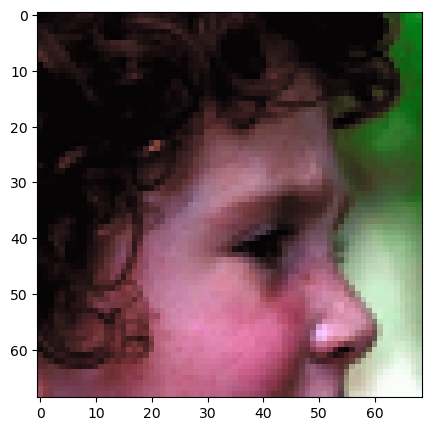

In [10]:
img_path = '/scratch_net/kringel/hchoong/github/quantum-cv/ScSR/data/val_lr/000005.png'

img_lr = mpimg.imread(img_path)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

imgplot = ax1.imshow(img_lr)

plt.show()

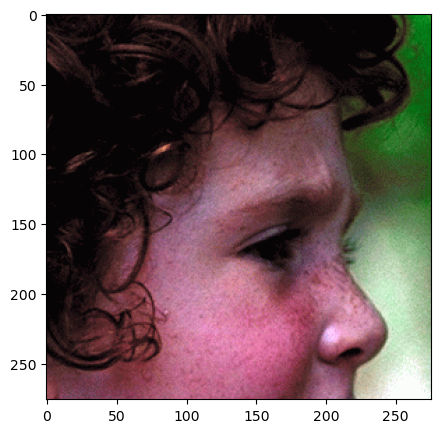

In [9]:
img_path = '/scratch_net/kringel/hchoong/github/quantum-cv/ScSR/data/val_hr/000005.png'

img_hr = mpimg.imread(img_path)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

imgplot = ax1.imshow(img_hr)

plt.show()

In [11]:
img_lr.shape

(69, 69, 3)